In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                self.layers.append(nn.Tanh())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


In [ ]:
def pde_loss(model, x, t, u, D):
    x.requires_grad_(True)
    t.requires_grad_(True)
    c = model(torch.cat([x, t], dim=1))
    c_t = torch.autograd.grad(c, t, torch.ones_like(c), create_graph=True)[0]
    c_x = torch.autograd.grad(c, x, torch.ones_like(c), create_graph=True)[0]
    c_xx = torch.autograd.grad(c_x, x, torch.ones_like(c_x), create_graph=True)[0]

    # Reaction term R(c) can be defined as needed, here we use a simple linear reaction for example
    R_c = -c  # Simple linear reaction term for illustration

    # Advection-Diffusion-Reaction equation
    pde_residual = c_t + u * c_x - D * c_xx - R_c

    return torch.mean(pde_residual**2)


In [ ]:
def train(model, optimizer, x, t, u, D, epochs=100):
    loss_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = pde_loss(model, x, t, u, D)
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

            # Plot intermediate results
            plot_solution(model, x, t, epoch)

    # Plot final loss history
    plt.figure()
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss History')
    plt.show()

def plot_solution(model, x, t, epoch):
    with torch.no_grad():
        X, T = torch.meshgrid(x.squeeze(), t.squeeze())
        X_flat = X.reshape(-1, 1)
        T_flat = T.reshape(-1, 1)
        C_pred = model(torch.cat([X_flat, T_flat], dim=1)).reshape(X.shape)

        plt.figure()
        plt.contourf(X.numpy(), T.numpy(), C_pred.numpy(), levels=50, cmap='viridis')
        plt.colorbar(label='Concentration')
        plt.xlabel('x')
        plt.ylabel('t')
        plt.title(f'Solution at Epoch {epoch}')
        plt.show()


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 0, Loss: 0.005693567916750908


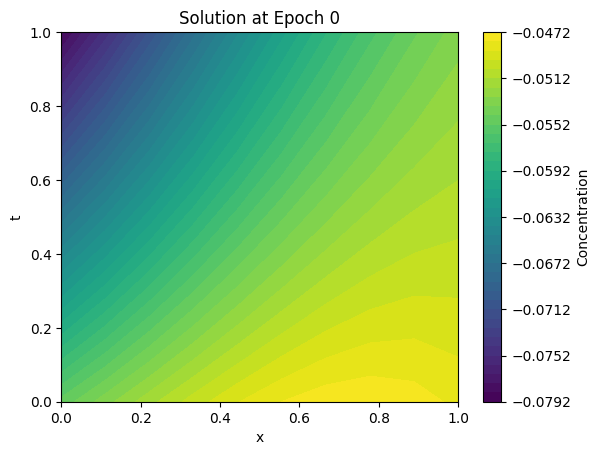

Epoch 10, Loss: 0.0015569735551252961


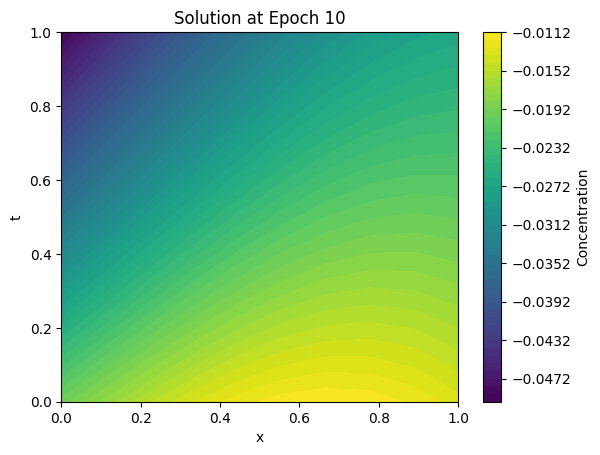

Epoch 20, Loss: 0.000500382564496249


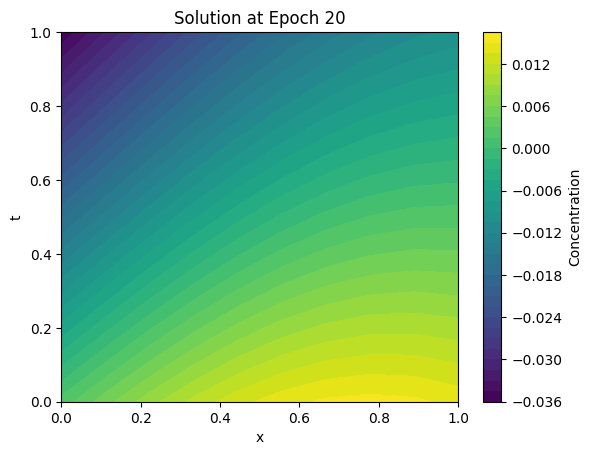

Epoch 30, Loss: 0.00014170826761983335


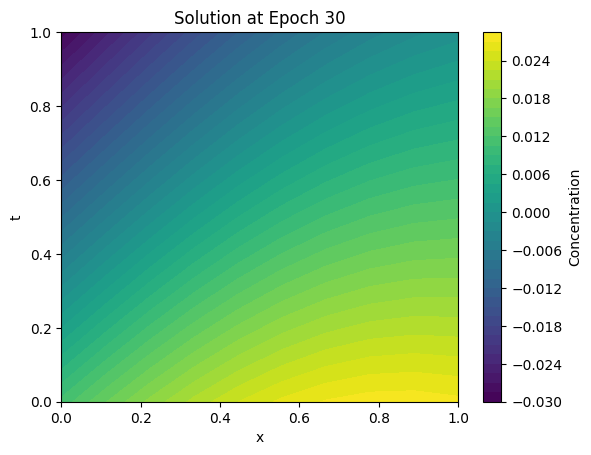

Epoch 40, Loss: 1.8320697563467547e-05


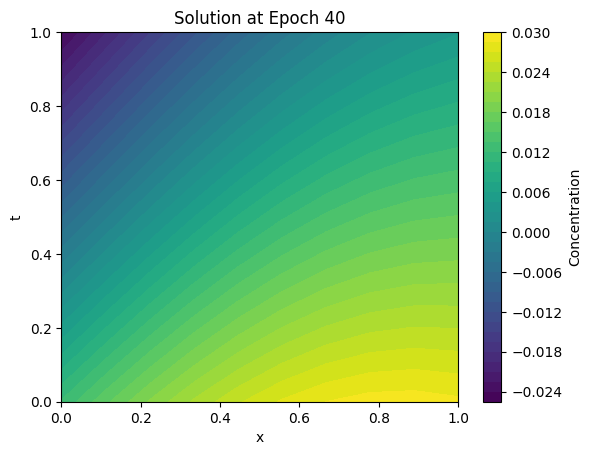

Epoch 50, Loss: 2.7228112230659463e-05


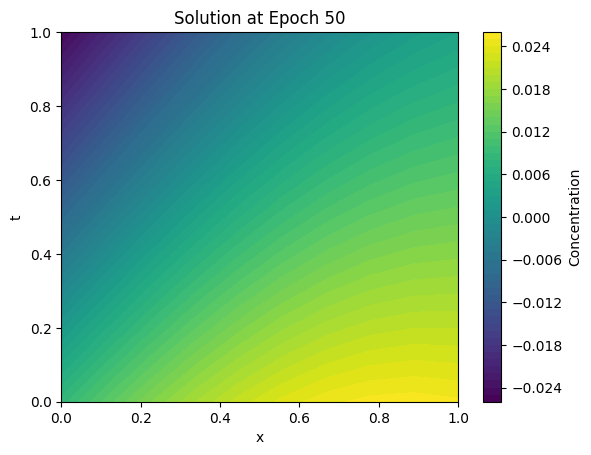

Epoch 60, Loss: 1.669215998845175e-05


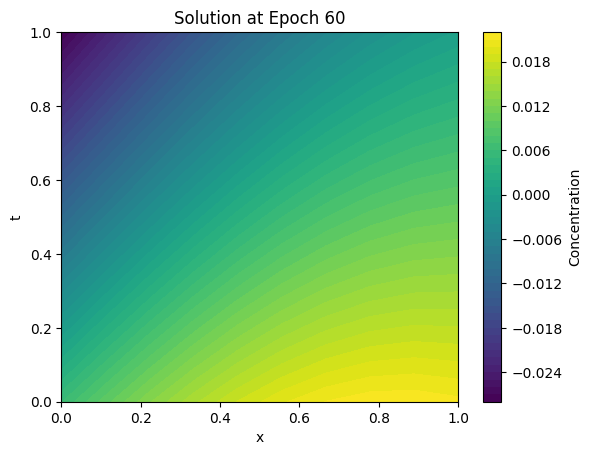

Epoch 70, Loss: 1.324359982390888e-05


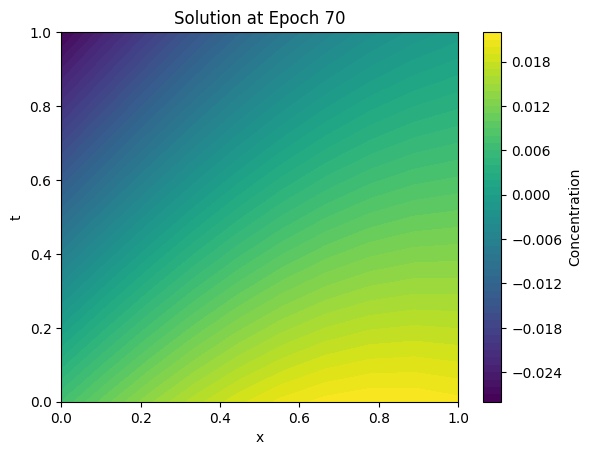

Epoch 80, Loss: 1.0149390618607868e-05


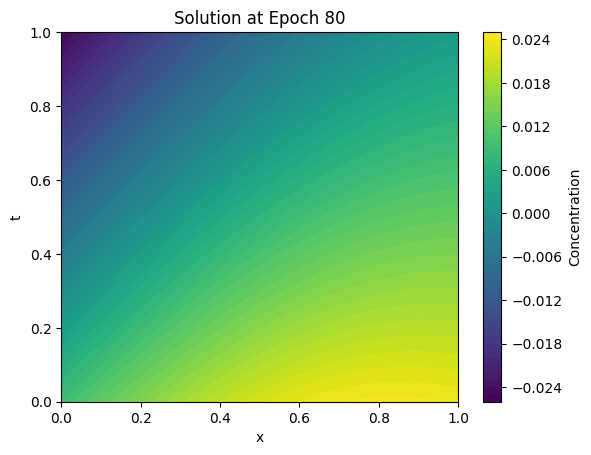

Epoch 90, Loss: 9.775869330042042e-06


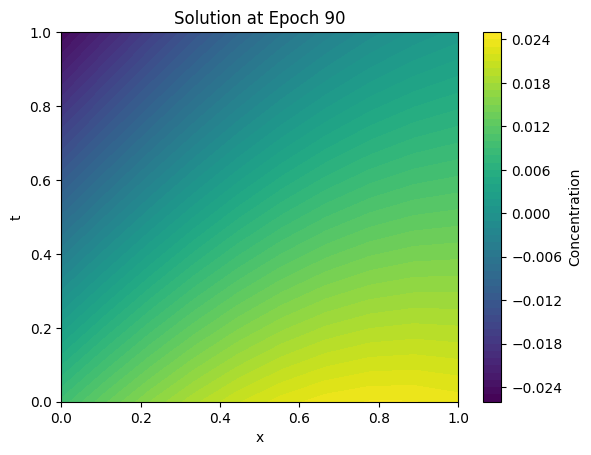

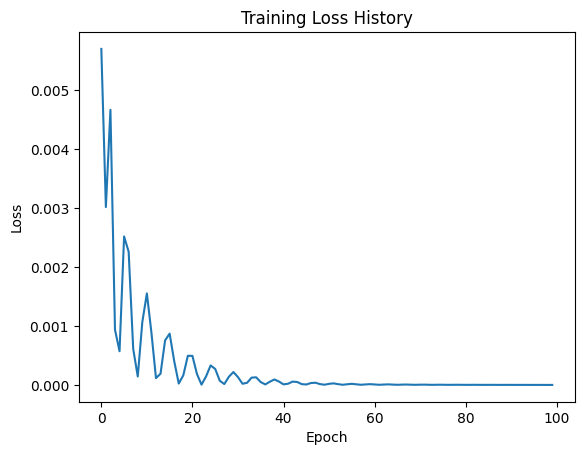

In [ ]:
if __name__ == "__main__":
    # Define parameters
    u = 1.0  # Velocity
    D = 0.1  # Diffusion coefficient

    # Generate training data
    x = torch.linspace(0, 1, 10).view(-1, 1)
    t = torch.linspace(0, 1, 10).view(-1, 1)

    # Create meshgrid for inputs
    X, T = torch.meshgrid(x.squeeze(), t.squeeze())
    X = X.reshape(-1, 1)
    T = T.reshape(-1, 1)

    # Initialize the PINN model
    layers = [2, 50, 50, 1]  # 2 input (x, t), two hidden layers with 50 neurons, 1 output (c)
    model = PINN(layers)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train(model, optimizer, X, T, u, D, epochs=100)


In [ ]:
#eularian box model 1

Epoch 0, Loss: 0.053589802235364914
Epoch 10, Loss: 0.009032603353261948
Epoch 20, Loss: 0.002942408435046673
Epoch 30, Loss: 0.0005536788376048207
Epoch 40, Loss: 8.974787488114089e-05
Epoch 50, Loss: 4.424952931003645e-05
Epoch 60, Loss: 3.964923234889284e-05
Epoch 70, Loss: 3.5102661058772355e-05
Epoch 80, Loss: 3.1756415410200134e-05
Epoch 90, Loss: 2.9445103791658767e-05


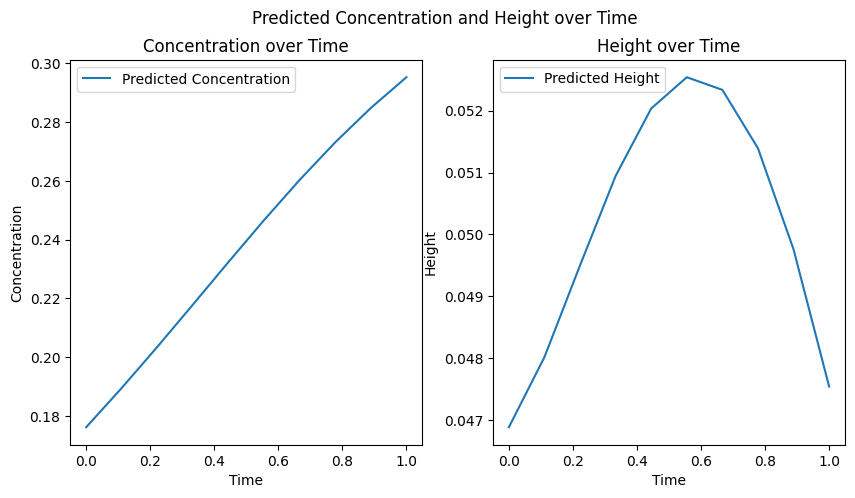

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                self.layers.append(nn.Tanh())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

def pde_loss(model, x, t, q, H, vd, u, dx, c0, R):
    x.requires_grad_(True)
    t.requires_grad_(True)

    c = model(torch.cat([x, t], dim=1))

    # Unpack concentrations and heights
    c, h = torch.split(c, 1, dim=1)

    # Calculate the concentration gradient with respect to time
    dc_dt = q / H + R + (vd / H) * c + (u / dx) * (c0 - c)

    # Calculate the height gradient with respect to time (if needed)
    dh_dt = 0  # Adjust this if height changes over time

    # Define the PDE residuals
    pde_residual_c = dc_dt - torch.autograd.grad(c, t, torch.ones_like(c), create_graph=True)[0]
    pde_residual_h = dh_dt - torch.autograd.grad(h, t, torch.ones_like(h), create_graph=True)[0]

    return torch.mean(pde_residual_c**2) + torch.mean(pde_residual_h**2)

def train(model, optimizer, x, t, q, H, vd, u, dx, c0, R, epochs=100):
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = pde_loss(model, x, t, q, H, vd, u, dx, c0, R)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

def plot_results(model, x, t, title):
    with torch.no_grad():
        c, h = model(torch.cat([x, t], dim=1)).split(1, dim=1)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(t.detach().numpy(), c.detach().numpy(), label='Predicted Concentration')
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.title('Concentration over Time')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(t.detach().numpy(), h.detach().numpy(), label='Predicted Height')
    plt.xlabel('Time')
    plt.ylabel('Height')
    plt.title('Height over Time')
    plt.legend()

    plt.suptitle(title)
    plt.show()

if __name__ == "__main__":
    # Define parameters
    q = 0.1 # Emission rate
    H = 100 # Height as a function of time
    vd = 0.05  # Dispersion velocity
    u = 2 # Wind speed
    dx = 10 # Spatial distance
    c0 =  1# Background concentration
    R =  0# Reaction term

    # Generate training data
    x = torch.linspace(0, 1, 10).view(-1, 1)
    t = torch.linspace(0, 1, 10).view(-1, 1)

    # Initialize the PINN model
    layers = [2, 50, 50, 2]  # 2 input (x, t), two hidden layers with 50 neurons, 2 output (c, h)
    model = PINN(layers)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train(model, optimizer, x, t, q, H, vd, u, dx, c0, R, epochs=100)

    # Plot results
    plot_results(model, x, t, 'Predicted Concentration and Height over Time')


eularian box model part 2

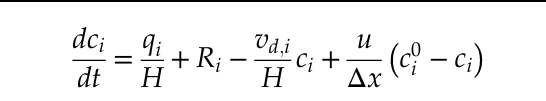

Epoch [40/200], Loss: 0.0284
Epoch [80/200], Loss: 0.0104
Epoch [120/200], Loss: 0.0076
Epoch [160/200], Loss: 0.0056
Epoch [200/200], Loss: 0.0039


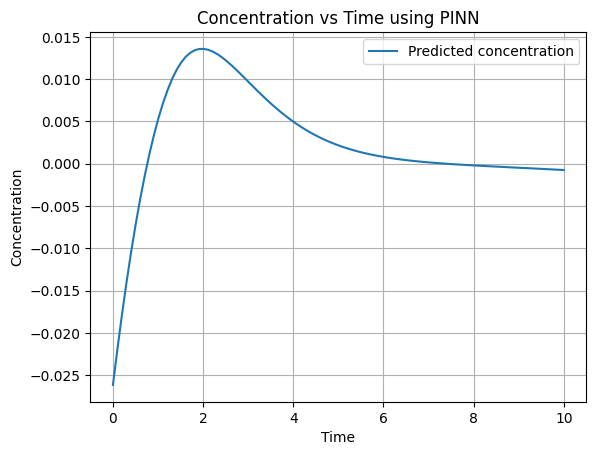

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Constants
H = 1000  # Height
q = 0.1   # Emission rate
R = 0.01   # Chemical production rate
v = 3   # Dry deposition velocity
u = 10000  # Wind speed
l = 1000 # Characteristic length
c0 = 0.002  # Background concentration

# Neural network definition
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer1 = nn.Linear(1, 20)
        self.hidden_layer2 = nn.Linear(20, 20)
        self.output_layer = nn.Linear(20, 1)
        self.activation = nn.Tanh()

    def forward(self, t):
        x = self.activation(self.hidden_layer1(t))
        x = self.activation(self.hidden_layer2(x))
        c = self.output_layer(x)
        return c

# Function to compute the derivative dc/dt using autograd
def compute_derivative(model, t):
    c = model(t)
    c_t = torch.autograd.grad(c, t, torch.ones_like(c), create_graph=True)[0]
    return c_t

# Loss function
def loss_function(model, t):
    c = model(t)
    c_t = compute_derivative(model, t)
    residual = c_t - (q / H + R - (v / H) * c + (u / l) * (c0 - c))
    loss = torch.mean(residual**2)
    return loss

# Generate training data
t = torch.linspace(0, 10, 100).view(-1, 1)
t.requires_grad = True

# Initialize model, optimizer
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_function(model, t)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 40 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Predictions
t_test = torch.linspace(0, 10, 100).view(-1, 1)
c_pred = model(t_test).detach().numpy()

# Plot results
plt.plot(t_test.numpy(), c_pred, label='Predicted concentration')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Concentration vs Time using PINN')
plt.legend()
plt.grid(True)
plt.show()



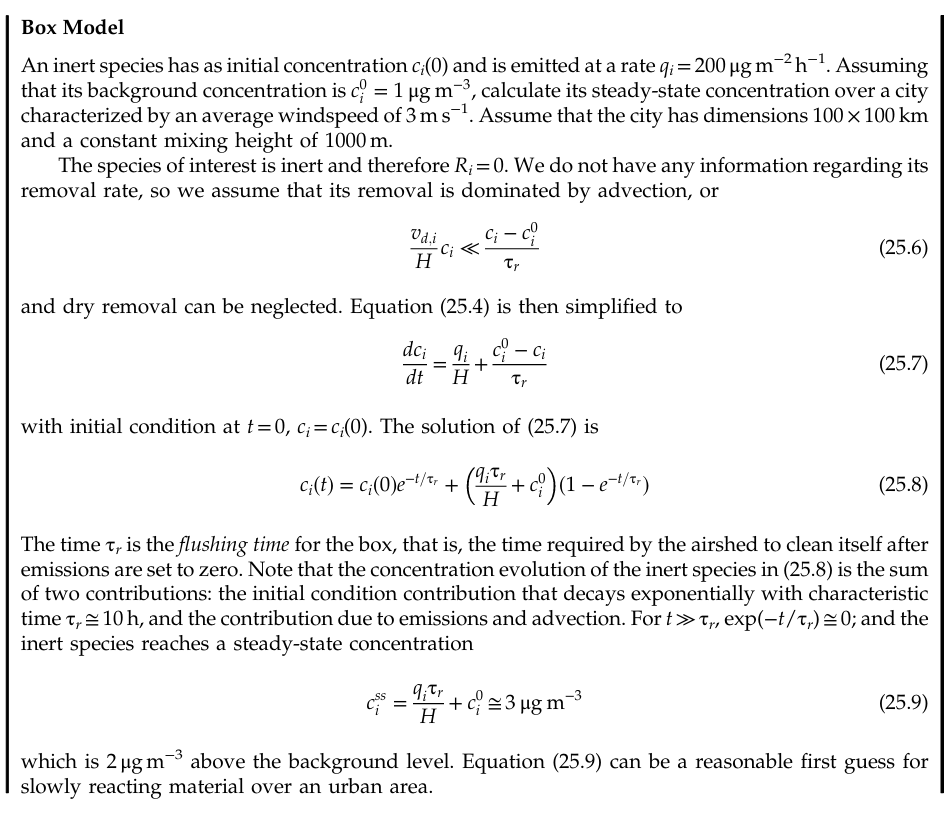

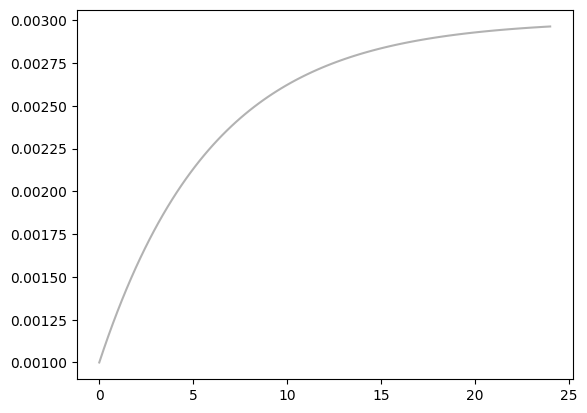

In [ ]:
H = 1000  # Height
q = 0.2   # Emission rate
tau = 10 # Characteristic length
c0 = 0.001
ci = 0.001
def exact_solution (H, q, tau,c0,ci,t):
  term1 = ci * np.exp(-t / tau)
  term2 = (q * tau / H + c0) * (1 - np.exp(-t / tau))
  return term1 + term2

t_test_act = torch.linspace (0,40,100). view (-1,1)
u_exact = exact_solution(H, q, tau,c0,ci, t_test_act)
plt.plot(t_test[:].squeeze(), u_exact[:].squeeze(), label="Exact solution", c="grey", alpha=0.6)

Epoch [5000/20000], Loss: 0.0000
Epoch [10000/20000], Loss: 0.0000
Epoch [15000/20000], Loss: 0.0000
Epoch [20000/20000], Loss: 0.0000


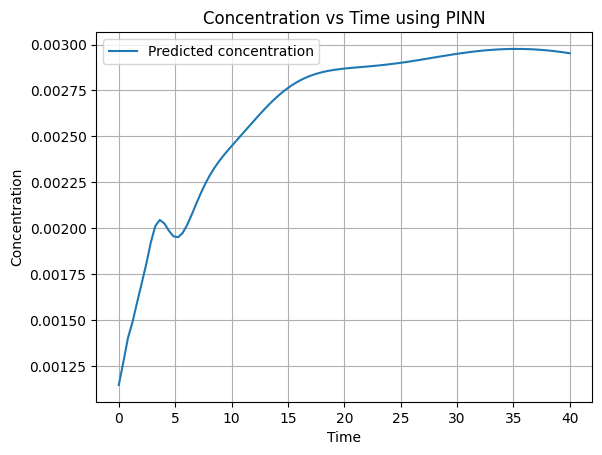

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Constants
H = 1000  # Height
q = 0.2   # Emission rate
tau = 10 # Characteristic length
c0 = 0.001
ci = 0.001 # Background concentration

# Neural network definition
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer1 = nn.Linear(1, 20)
        self.hidden_layer2 = nn.Linear(20, 20)
        self.output_layer = nn.Linear(20, 1)
        self.activation = nn.Tanh()

    def forward(self, t):
        x = self.activation(self.hidden_layer1(t))
        x = self.activation(self.hidden_layer2(x))
        c = self.output_layer(x)
        return c
t_boundary= torch. tensor (0.). view (-1, 1).requires_grad_(True)
# Function to compute the derivative dc/dt using autograd
def compute_derivative(model, t):

    c = model(t)
    c_t = torch.autograd.grad(c, t, torch.ones_like(c), create_graph=True)[0]
    return c_t

# Loss function
def loss_function(model, t):
    c = model(t)
    c_t = compute_derivative(model, t)
    residual = c_t - q / H - (c0 - c) / tau
    loss1 = torch.mean(residual**2)
    u = model(t_boundary)
    loss2 = (torch.squeeze(u)-ci)**2
    return loss2 + loss1


# Generate training data
t = torch.linspace(0, 40, 100).view(-1, 1)
t.requires_grad = True

# Initialize model, optimizer
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_function(model, t)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Predictions
t_test = torch.linspace(0, 40, 100).view(-1, 1)
c_pred = model(t_test).detach().numpy()

# Plot results
plt.plot(t_test.numpy(), c_pred, label='Predicted concentration')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Concentration vs Time using PINN')
plt.legend()
plt.grid(True)
plt.show()



Epoch [5000/20000], Loss: 0.0000
Epoch [10000/20000], Loss: 0.0000
Epoch [15000/20000], Loss: 0.0000
Epoch [20000/20000], Loss: 0.0000


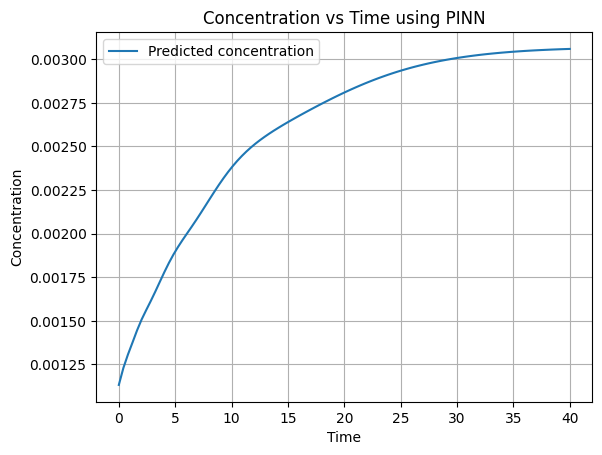

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Constants
H = 1000  # Height
q = 0.2   # Emission rate
tau = 10 # Characteristic length
c0 = 0.001
ci = 0.001 # Background concentration

# Neural network definition
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer1 = nn.Linear(1, 20)
        self.hidden_layer2 = nn.Linear(20, 20)
        self.output_layer = nn.Linear(20, 1)
        self.activation = nn.Tanh()

    def forward(self, t):
        x = self.activation(self.hidden_layer1(t))
        x = self.activation(self.hidden_layer2(x))
        c = self.output_layer(x)
        return c
t_boundary= torch. tensor (0.). view (-1, 1).requires_grad_(True)
# Function to compute the derivative dc/dt using autograd
def compute_derivative(model, t):

    c = model(t)
    c_t = torch.autograd.grad(c, t, torch.ones_like(c), create_graph=True)[0]
    return c_t

# Loss function
def loss_function(model, t):
    c = model(t)
    c_t = compute_derivative(model, t)
    residual = c_t - q / H - (c0 - c) / tau
    loss1 = torch.mean(residual**2)
    u = model(t_boundary)
    loss2 = (torch.squeeze(u)-ci)**2
    return loss2 + 10*loss1


# Generate training data
t = torch.linspace(0, 40, 100).view(-1, 1)
t.requires_grad = True

# Initialize model, optimizer
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_function(model, t)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Predictions
t_test = torch.linspace(0, 40, 100).view(-1, 1)
c_pred = model(t_test).detach().numpy()

# Plot results
plt.plot(t_test.numpy(), c_pred, label='Predicted concentration')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Concentration vs Time using PINN')
plt.legend()
plt.grid(True)
plt.show()



further updation
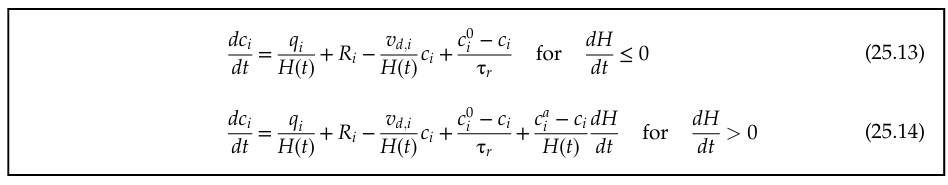

lagrangian model

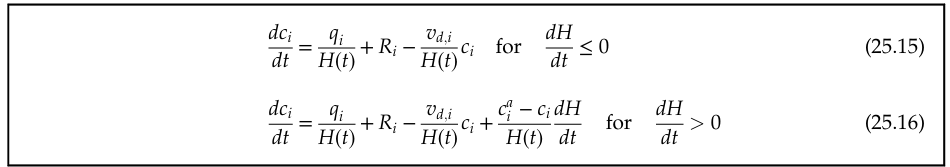

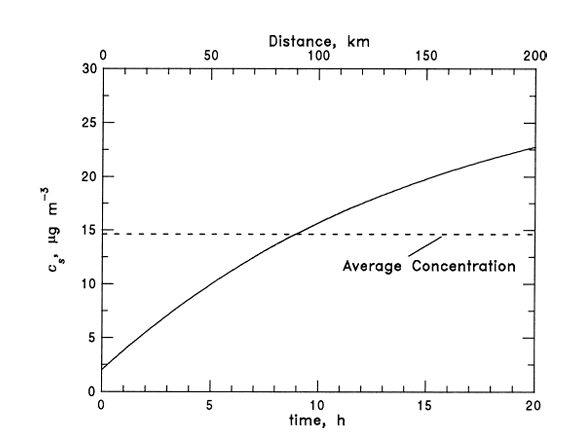

In [ ]:
#sample

Epoch 0, Loss: 8.817511558532715
Epoch 1000, Loss: 0.2830428183078766
Epoch 2000, Loss: 0.008544969372451305
Epoch 3000, Loss: 0.00039584762998856604
Epoch 4000, Loss: 7.768649084027857e-05
Epoch 5000, Loss: 2.7201469492865726e-05
Epoch 6000, Loss: 1.165456160379108e-05
Epoch 7000, Loss: 6.2853159761289135e-06
Epoch 8000, Loss: 3.1716326702735387e-06
Epoch 9000, Loss: 1.7758202375262044e-06


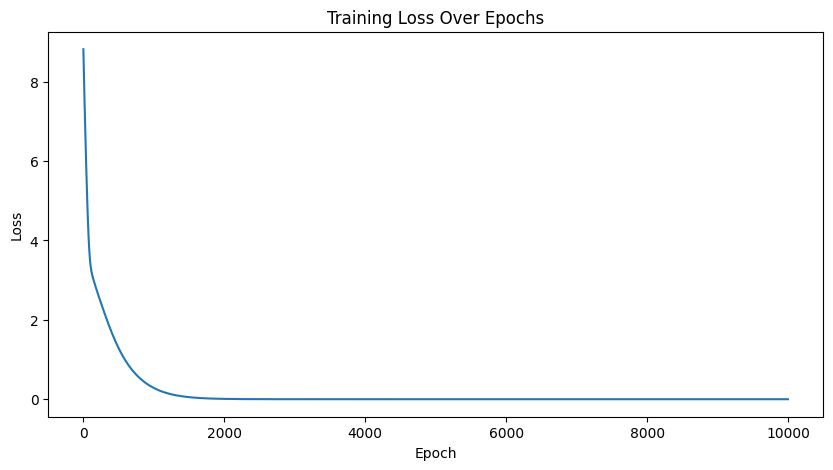

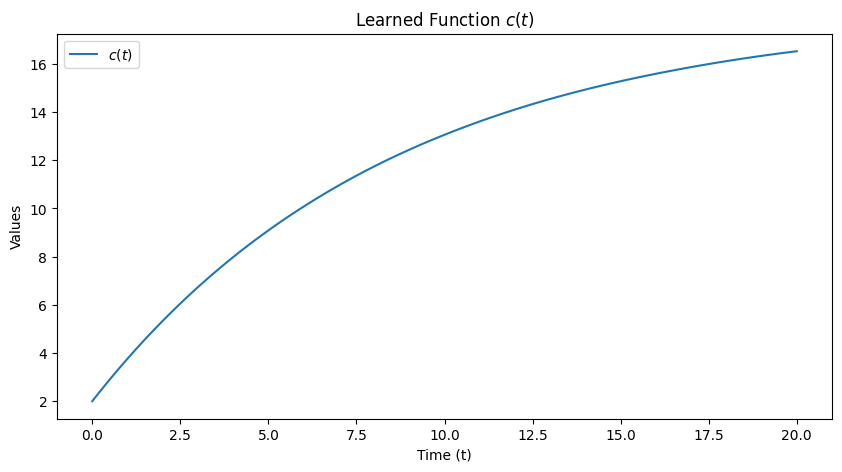

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the neural network architecture
c0 = 2
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 1)  # Output: c(t)

    def forward(self, t):
        x = torch.tanh(self.fc1(t))
        x = torch.tanh(self.fc2(x))
        c = self.fc3(x)
        return c
t_boundary= torch. tensor (0.). view (-1, 1).requires_grad_(True)
# Define the physics-based loss function
def physics_loss(model, t, A, B):
    # Predict c at time t
    c = model(t)

    # Compute the derivative using autograd
    c_t = torch.autograd.grad(c, t, grad_outputs=torch.ones_like(c), create_graph=True)[0]

    # Compute the residual of the differential equation
    res = c_t - (A - B * c)

    # Mean squared error of the residual
    loss = torch.mean(res**2)
    u = model(t_boundary)
    loss1 = (torch.squeeze(u)-c0)**2
    return loss+loss1

# Hyperparameters
learning_rate = 1e-3
epochs = 10000

# Initialize the model, optimizer
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
loss_history = []
for epoch in range(epochs):
    optimizer.zero_grad()

    # Sample time points
    t = torch.linspace(0, 20, 100).view(-1, 1).requires_grad_(True)  # Example time range from 0 to 10

    # Constants (example values)
    A = 2.1
    B = 0.116

    # Compute the loss
    loss = physics_loss(model, t, A, B)

    # Backpropagation
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Plot the loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

# Plot the learned function c(t)
t = torch.linspace(0, 20, 100).view(-1, 1)  # Example time range from 0 to 10
c_pred = model(t).detach().numpy()

plt.figure(figsize=(10, 5))
plt.plot(t.numpy(), c_pred, label='$c(t)$')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.title('Learned Function $c(t)$')
plt.legend()
plt.show()


main lagrangian box model

Epoch 0, Loss: 0.0005587704945355654
Epoch 5000, Loss: 0.0002530357160139829
Epoch 10000, Loss: 0.00018655226449482143
Epoch 15000, Loss: 5.8456418628338724e-05
Epoch 20000, Loss: 3.970422767451964e-05
Epoch 25000, Loss: 4.9532529374118894e-05


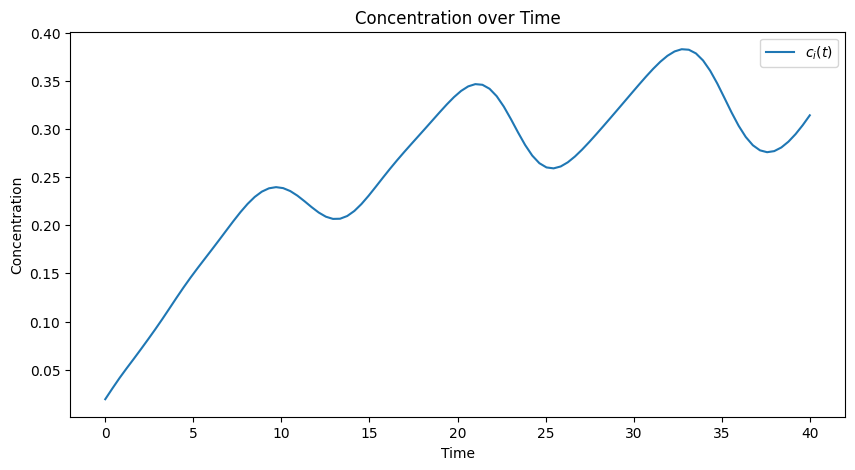

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(1, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, t):
        x = t
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        outputs = self.fc3(x)
        return outputs


def physics_loss(model, t, q, R, v, c):

    predictions = model(t)
    c_t = predictions[:]
    H = 750 + 375 * (1 + torch.sin(2 * 3.14 * t / 12))

    c_t_grad = torch.autograd.grad(c_t, t, grad_outputs=torch.ones_like(c_t), create_graph=True)[0]
    H_grad = torch.autograd.grad(H, t, grad_outputs=torch.ones_like(H), create_graph=True)[0]


    res_leq = c_t_grad - (q / H + R - v * c_t / H)
    res_gt = c_t_grad - (q / H + R - v * c_t / H + (c - c_t) * H_grad / H)

    # Applying conditions
    loss_leq = torch.mean((H_grad <= 0).float() * res_leq**2)
    loss_gt = torch.mean((H_grad > 0).float() * res_gt**2)

    # Boundary condition loss
    t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)
    u = model(t_boundary)
    loss_bc = (u - c)**2


    loss = loss_leq + loss_gt + 1e-2*loss_bc
    return loss


learning_rate = 1e-3
epochs = 30000


model = PINN()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()

    t = torch.linspace(0, 40, 100).view(-1, 1).requires_grad_(True)

    # Constants (example values)
    q = 0.2
    R = 0.03
    v = 36  # m/h
    c = 0.02


    loss = physics_loss(model, t, q, R, v, c)


    loss.backward()
    optimizer.step()

    if epoch % 5000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Generate predictions
t = torch.linspace(0, 40, 100).view(-1, 1)
predictions = model(t).detach().numpy()

# Plot results
plt.figure(figsize=(10, 5))

plt.plot(t.detach().numpy(), predictions[:, 0], label='$c_i(t)$')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Concentration over Time')
plt.legend()



plt.show()


Epoch 0, Loss: 0.0011807364644482732
Epoch 5000, Loss: 0.0001809560926631093
Epoch 10000, Loss: 0.00017800249042920768
Epoch 15000, Loss: 0.00010146618296857923
Epoch 20000, Loss: 7.828669913578779e-05
Epoch 25000, Loss: 6.425290484912694e-05
Epoch 30000, Loss: 4.7828812967054546e-05


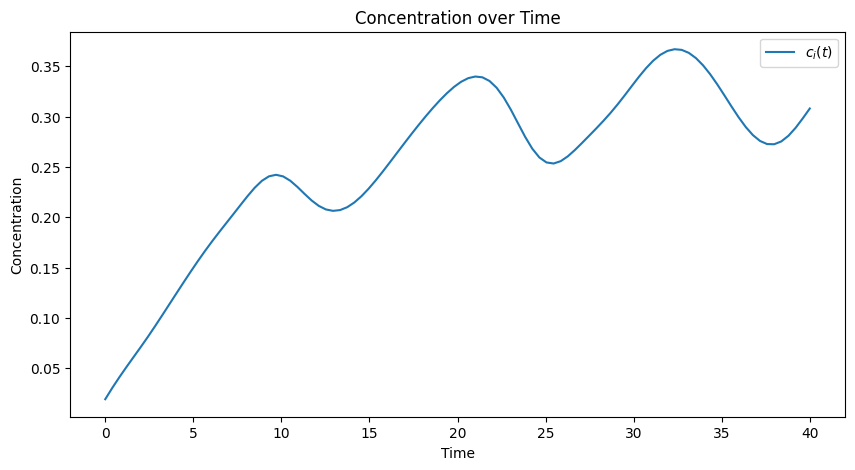

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(1, 60)
        self.fc2 = nn.Linear(60, 60)
        self.fc3 = nn.Linear(60, 1)

    def forward(self, t):
        x = t
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        outputs = self.fc3(x)
        return outputs


def physics_loss(model, t, q, R, v, c):

    predictions = model(t)
    c_t = predictions[:]
    H = 750 + 375 * (1 + torch.sin(2 * 3.14 * t / 12))

    c_t_grad = torch.autograd.grad(c_t, t, grad_outputs=torch.ones_like(c_t), create_graph=True)[0]
    H_grad = torch.autograd.grad(H, t, grad_outputs=torch.ones_like(H), create_graph=True)[0]


    res_leq = c_t_grad - (q / H + R - v * c_t / H)
    res_gt = c_t_grad - (q / H + R - v * c_t / H + (c - c_t) * H_grad / H)

    # Applying conditions
    loss_leq = torch.mean((H_grad <= 0).float() * res_leq**2)
    loss_gt = torch.mean((H_grad > 0).float() * res_gt**2)

    # Boundary condition loss
    t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)
    u = model(t_boundary)
    loss_bc = (u - c)**2


    loss = loss_leq + loss_gt + 1e-2*loss_bc
    return loss


learning_rate = 1e-3
epochs = 35000


model = PINN()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()

    t = torch.linspace(0, 40, 100).view(-1, 1).requires_grad_(True)

    # Constants (example values)
    q = 0.2
    R = 0.03
    v = 36  # m/h
    c = 0.02


    loss = physics_loss(model, t, q, R, v, c)


    loss.backward()
    optimizer.step()

    if epoch % 5000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Generate predictions
t = torch.linspace(0, 40, 100).view(-1, 1)
predictions = model(t).detach().numpy()

# Plot results
plt.figure(figsize=(10, 5))

plt.plot(t.detach().numpy(), predictions[:, 0], label='$c_i(t)$')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Concentration over Time')
plt.legend()



plt.show()


ground truth

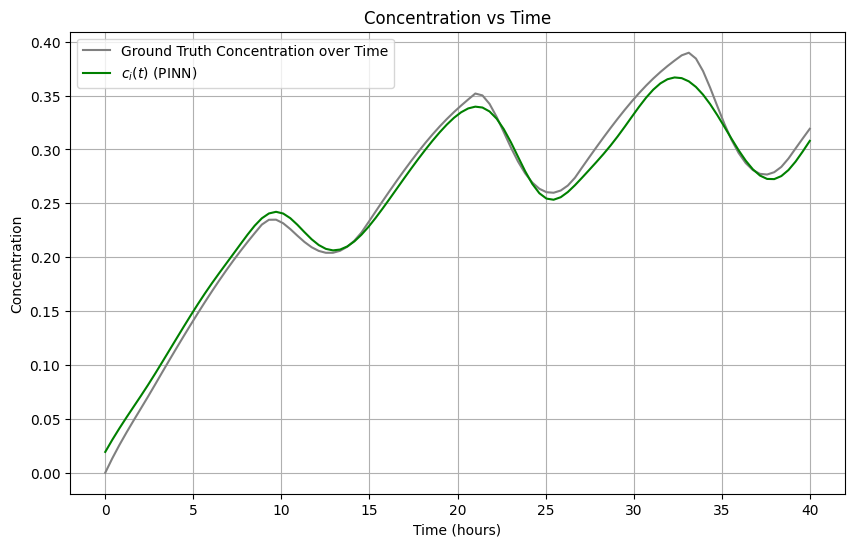

In [ ]:

# Constants
q = 0.2
R = 0.03
v = 36
ca = 0.02
t = torch.linspace(0, 40, 100)
H = 750 + 375 * (1 + torch.sin(2 * 3.14 * t / 12))

# Differential equation (for dH/dt <= 0 and dH/dt > 0)
def dci_dt(ci, H, dH_dt):
    if dH_dt <= 0:
        return q / H + R - (v * ci / H)
    else:
        return q / H + R - (v * ci / H) + (ca - ci) * dH_dt / H


dH_dt = torch.gradient(H, spacing=(t,))[0]

# Initial concentration
ci = torch.zeros(1)

# Solve the differential equation using Euler's method
dt = t[1] - t[0]
concentration = [ci.item()]

for i in range(1, len(t)):
    ci_new = concentration[-1] + dci_dt(concentration[-1], H[i], dH_dt[i]) * dt
    concentration.append(ci_new.item())

concentration = torch.tensor(concentration)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t.numpy(), concentration.numpy(), label='Ground Truth Concentration over Time',color='grey')
plt.plot(t.detach().numpy(), predictions[:, 0], label='$c_i(t)$ (PINN)',color='green')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration')
plt.title('Concentration vs Time')
plt.legend()
plt.grid(True)
plt.show()
